# EEE486 - Assignment 2 Part 2

In [ ]:
%%capture
!pip install datasets transformers
!pip install optuna
!pip install matplotlib

In [ ]:
import torch
import time
import datetime
import random
from random import seed
import numpy as np
from sklearn.metrics import accuracy_score
import torch.utils.data as Data
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import optuna
import torch.nn as nn
from datasets import load_dataset
from transformers import AutoTokenizer, BertModel, get_linear_schedule_with_warmup, logging

In [ ]:
def get_device():
    if torch.backends.cuda.is_built():
        print("CUDA")
        device = torch.device("cuda")
    elif torch.backends.mps.is_built():
        print("mps")
        device = torch.device("mps")
    else:
        device = torch.device("cpu")
        raise Exception("GPU is not avalaible!")
    return device


In [ ]:
# Function to calculate the accuracy of our predictions vs labels
def flat_accuracy(preds, labels):
    pred_flat = np.argmax(preds, axis=1).flatten()
    labels_flat = labels.flatten()
    return np.sum(pred_flat == labels_flat) / len(labels_flat)


def format_time(elapsed):
    elapsed_rounded = int(round((elapsed)))
    return str(datetime.timedelta(seconds=elapsed_rounded))


In [ ]:
class MeanPoolingBertForClassification(nn.Module):
    def __init__(self, num_labels=2, dropout_rate=0.1):
        super(MeanPoolingBertForClassification, self).__init__()
        self.num_labels = num_labels
        self.dropout_rate = dropout_rate

        # loading pre-trained BERT
        self.bert = BertModel.from_pretrained(
            'bert-base-uncased',
            output_hidden_states=True  
        )

        # classifier layers 
        self.dropout = nn.Dropout(dropout_rate)

        # multi-layer classifier 
        self.classifier = nn.Sequential(
            nn.Linear(768*2, 512), 
            nn.ReLU(),
            nn.Dropout(dropout_rate),
            nn.Linear(512, num_labels)
        )

    def forward(self, input_ids, attention_mask=None, token_type_ids=None, labels=None):
        outputs = self.bert(
            input_ids,
            attention_mask=attention_mask,
            token_type_ids=token_type_ids,
            output_hidden_states=True 
        )

        sequence_output = outputs.last_hidden_state  

        pooled_output = outputs.pooler_output 

        input_mask_expanded = attention_mask.unsqueeze(-1).expand(sequence_output.size()).float()
        sum_embeddings = torch.sum(sequence_output * input_mask_expanded, 1)
        sum_mask = input_mask_expanded.sum(1)
        sum_mask = torch.clamp(sum_mask, min=1e-9)
        mean_pooled = sum_embeddings / sum_mask 

        # combine mean pooling and CLS token representation
        combined_output = torch.cat([mean_pooled, pooled_output], dim=1)  # [batch_size, hidden_size*2]

        combined_output = self.dropout(combined_output)
        logits = self.classifier(combined_output)

        loss = None
        if labels is not None:
            loss_fct = nn.CrossEntropyLoss()
            loss = loss_fct(logits.view(-1, self.num_labels), labels.view(-1))

        return type('BertOutput', (), {
            'loss': loss,
            'logits': logits
        })

In [ ]:
# Function to train and evaluate the model
def train_eval_loop(
    model, loader, optimizer, scheduler, device, n_epochs=2, seed_val=42
):
    # Set the seed value all over the place to make this reproducible.
    random.seed(seed_val)
    np.random.seed(seed_val)
    torch.manual_seed(seed_val)
    torch.cuda.manual_seed_all(seed_val)

    training_stats = []
    loss_values = []
    val_acc_values = []
    val_loss_values = []
    best_val_acc = 0  
    best_model_state = None  # Save the state of the best model

    t00 = time.time()
    for epoch_i in range(0, n_epochs):
        print("")
        print("======== Epoch {:} / {:} ========".format(epoch_i + 1, n_epochs))
        print("Training...")

        # Measure how long the training epoch takes.
        t0 = time.time()

        # Reset the total loss for this epoch.
        total_loss = 0
        model.train()

        # For each batch of training data...
        for step, batch in enumerate(loader["train"]):
            # print('Memory Usage:')
            # print('Allocated:', round(torch.mps.driver_allocated_memory()/1024**3,1), 'GB')
            
            b_input_ids, b_input_mask, b_token_type_ids, b_labels = tuple(t.to(device) for t in batch)

            model.zero_grad()

            outputs = model(
                b_input_ids,
                attention_mask=b_input_mask,
                token_type_ids=b_token_type_ids,
                labels=b_labels
            )

            loss = outputs.loss
            total_loss += loss.item()
            loss.backward()

            # Clip the norm of the gradients to 1.0
            torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
            optimizer.step()
            scheduler.step()

        avg_train_loss = total_loss / len(loader["train"])
        loss_values.append(avg_train_loss)

        print("\nAverage training loss: {0:.2f}".format(avg_train_loss))
        print("  Training epoch took: {:}".format(format_time(time.time() - t0)))

        print("\nRunning Validation...")
        t0 = time.time()
        model.eval()
        val_acc, nb_eval_steps = 0, 0
        val_loss = 0

        for batch in loader["validation"]:
            # print('Memory Usage:')
            # print('Allocated:', round(torch.mps.driver_allocated_memory()/1024**3,1), 'GB')
            b_input_ids, b_input_mask, b_token_type_ids, b_labels = tuple(t.to(device) for t in batch)

            with torch.no_grad():
                outputs = model(
                    b_input_ids,
                    attention_mask=b_input_mask,
                    token_type_ids=b_token_type_ids,
                    labels=b_labels
                )
                loss = outputs.loss
                logits = outputs.logits
                val_loss += loss.item()

            if isinstance(logits, torch.Tensor):
                logits = logits.detach().cpu().numpy()
                preds = np.argmax(logits, axis=1).flatten()
            else:
                preds = np.argmax(logits.detach().cpu().numpy(), axis=1).flatten()

            label_ids = b_labels.to("cpu").numpy()

            val_acc += accuracy_score(preds, label_ids)
            nb_eval_steps += 1

        avg_val_loss = val_loss / nb_eval_steps
        val_loss_values.append(avg_val_loss)
        val_acc_value = val_acc / nb_eval_steps
        current_val_acc = val_acc_value * 100
        val_acc_values.append(current_val_acc) 

        if current_val_acc > best_val_acc:
            best_val_acc = current_val_acc
            # save the model state dictionary
            best_model_state = model.state_dict().copy()
            print(f"  New best validation accuracy: {best_val_acc:.2f}%")

        # record all statistics for this epoch
        training_stats.append(
            {
                'epoch': epoch_i + 1,
                'training_loss': avg_train_loss,
                'valid_loss': avg_val_loss,
                'valid_accuracy': current_val_acc,
                'training_time': format_time(time.time() - t0),
            }
        )

        print("  Validation Loss: {0:.2f}".format(avg_val_loss))
        print("  Validation ACC: {0:.2f}%".format(current_val_acc))
        print("  Validation took: {:}".format(format_time(time.time() - t0)))

    df_stats = pd.DataFrame(training_stats)

    df_stats = df_stats.set_index('epoch')

    # display
    print("\nTraining & Validation Statistics:")
    print(df_stats)

    if best_model_state is not None:
        model.load_state_dict(best_model_state)
        print(f"Loaded best model with validation accuracy: {best_val_acc:.2f}%")

    return best_val_acc, loss_values, val_acc_values, val_loss_values, df_stats


In [ ]:
def init_loader(max_length=16, batch_size=32, test_size=0.2, random_state=2023):
    model_checkpoint = "bert-base-uncased"

    dataset = load_dataset("glue", "rte")

    # Load tokenizer
    tokenizer = AutoTokenizer.from_pretrained(model_checkpoint, use_fast=True)

    # Define dictionaries to store processed data
    df_s, x, y = {}, {}, {}
    input_ids, attention_mask, token_type_ids = {}, {}, {}
    datasets, loader = {}, {}

    for split in ["train", "validation", "test"]:
        # Convert dataset to pandas
        df_s[split] = dataset[split].to_pandas()

        # Extract premise and hypothesis for RTE
        premise = dataset[split]["sentence1"]
        hypothesis = dataset[split]["sentence2"]
        y[split] = dataset[split]["label"]  # Labels

        # Store sentence pairs
        x[split] = list(zip(premise, hypothesis))

        # Tokenize as sentence pairs
        input = tokenizer(
            premise,
            hypothesis,
            max_length=max_length,
            truncation=True,
            padding="max_length",
            return_tensors="pt",
            return_token_type_ids=True  
        )

        input_ids[split] = input.input_ids
        attention_mask[split] = input.attention_mask
        token_type_ids[split] = input.token_type_ids

        datasets[split] = Data.TensorDataset(
            input_ids[split],
            attention_mask[split],
            token_type_ids[split],
            torch.LongTensor(y[split])
        )

        loader[split] = Data.DataLoader(
            datasets[split], batch_size=batch_size, shuffle=(split == "train")
        )
    return loader, y

In [ ]:
def init_objects(
    lr, n_epochs, max_length=16, batch_size=32, dropout_rate=0.1, test_size=0.2, random_state=2023
):
    loader, _ = init_loader(max_length=max_length, batch_size=batch_size)

    model = MeanPoolingBertForClassification(
        num_labels=2,
        dropout_rate=dropout_rate
    )

    no_decay = ['bias', 'LayerNorm.weight']
    optimizer_grouped_parameters = [
        {
            'params': [p for n, p in model.named_parameters() if not any(nd in n for nd in no_decay)],
            'weight_decay': 0.01
        },
        {
            'params': [p for n, p in model.named_parameters() if any(nd in n for nd in no_decay)],
            'weight_decay': 0.0
        }
    ]

    optimizer = torch.optim.AdamW(optimizer_grouped_parameters, lr=lr, eps=1e-8)

    total_steps = len(loader["train"]) * n_epochs
    scheduler = get_linear_schedule_with_warmup(
        optimizer, num_warmup_steps=int(0.1 * total_steps), num_training_steps=total_steps
    )

    return model, loader, optimizer, scheduler

In [ ]:
class MeanPoolingBertObjective:
    def __init__(self, d, device):
        self.d = d
        self.device = device

    def __call__(self, trial: optuna.trial.Trial):
        self.lr = trial.suggest_float("lr", self.d["lr"][0], self.d["lr"][1], log=True)
        self.n_epochs = trial.suggest_categorical("n_epochs", self.d["n_epochs"])
        self.max_length = trial.suggest_categorical("max_length", self.d["max_length"])
        self.batch_size = trial.suggest_categorical("batch_size", self.d["batch_size"])
        self.dropout_rate = trial.suggest_float("dropout_rate", self.d["dropout_rate"][0], self.d["dropout_rate"][1])

        model, loader, optimizer, scheduler = init_objects(
            self.lr,
            self.n_epochs,
            self.max_length,
            self.batch_size,
            self.dropout_rate
        )

        model.to(self.device)

        val_acc, _, _, _, _ = train_eval_loop(
            model, loader, optimizer, scheduler, self.device, self.n_epochs
        )

        return val_acc

In [ ]:
def run_hyperparameter_tuning(n_trials=10):
    param_dict = {
        "lr": [5e-6, 3e-5],  
        "n_epochs": [3, 4, 5, 6, 7], 
        "max_length": [48, 64, 128],  
        "batch_size": [16, 32],  
        "dropout_rate": [0.1, 0.2, 0.3], 
    }

    # Set the device
    device = get_device()
    print(f"Using device: {device}")

    study = optuna.create_study(study_name="Enhanced_Mean_Pooling_BERT_Study", direction="maximize")
    study.optimize(MeanPoolingBertObjective(param_dict, device), n_trials=n_trials)

    print("Best trial:")
    trial = study.best_trial
    print(f"  Value: {trial.value}")
    print("  Params: ")
    for key, value in trial.params.items():
        print(f"    {key}: {value}")

    best_lr = trial.params["lr"]
    best_n_epochs = trial.params["n_epochs"]
    best_max_length = trial.params["max_length"]
    best_batch_size = trial.params["batch_size"]
    best_dropout_rate = trial.params["dropout_rate"]

    model, loader, optimizer, scheduler = init_objects(
        best_lr,
        best_n_epochs,
        best_max_length,
        best_batch_size,
        best_dropout_rate
    )

    model.to(device)

    val_acc, loss_values, val_acc_values, val_loss_values, df_stats = train_eval_loop(
        model, loader, optimizer, scheduler, device, best_n_epochs
    )

    print(f"Final validation accuracy with best parameters: {val_acc:.2f}%")

    plt.figure(figsize=(15, 5))

    plt.subplot(1, 2, 1)
    epochs = range(1, len(loss_values) + 1)
    plt.plot(epochs, loss_values, 'b-', label='Training Loss')
    plt.plot(epochs, val_loss_values, 'r-', label='Validation Loss')
    plt.title('Training and Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(epochs, val_acc_values, 'g-o')
    plt.title('Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy (%)')

    plt.tight_layout()
    plt.savefig('mean_pooling_training_metrics.png')
    plt.close()

    param_importances = optuna.importance.get_param_importances(study)
    importance_df = pd.DataFrame(
        {'Parameter': list(param_importances.keys()),
         'Importance': list(param_importances.values())}
    )

    plt.figure(figsize=(10, 6))
    sns.barplot(x='Parameter', y='Importance', data=importance_df)
    plt.title('Hyperparameter Importance')
    plt.xlabel('Parameter')
    plt.ylabel('Importance')
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.savefig('hyperparameter_importance.png')
    plt.close()

    return model, val_acc, trial.params, loss_values, val_acc_values, val_loss_values, df_stats

[I 2025-04-10 18:06:55,829] A new study created in memory with name: Enhanced_Mean_Pooling_BERT_Study


Part 2: Mean Pooling BERT Model for Text Classification
Running hyperparameter optimization with 10 trials
CUDA
Using device: cuda


/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


README.md:   0%|          | 0.00/35.3k [00:00<?, ?B/s]

train-00000-of-00001.parquet:   0%|          | 0.00/584k [00:00<?, ?B/s]

validation-00000-of-00001.parquet:   0%|          | 0.00/69.0k [00:00<?, ?B/s]

test-00000-of-00001.parquet:   0%|          | 0.00/621k [00:00<?, ?B/s]

Generating train split:   0%|          | 0/2490 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/277 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/3000 [00:00<?, ? examples/s]

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]


======== Epoch 1 / 5 ========
Training...

Average training loss: 0.69
  Training epoch took: 0:00:06

Running Validation...
  New best validation accuracy: 55.65%
  Validation Loss: 0.68
  Validation ACC: 55.65%
  Validation took: 0:00:00

======== Epoch 2 / 5 ========
Training...

Average training loss: 0.68
  Training epoch took: 0:00:05

Running Validation...
  New best validation accuracy: 61.92%
  Validation Loss: 0.66
  Validation ACC: 61.92%
  Validation took: 0:00:00

======== Epoch 3 / 5 ========
Training...

Average training loss: 0.62
  Training epoch took: 0:00:05

Running Validation...
  Validation Loss: 0.65
  Validation ACC: 59.84%
  Validation took: 0:00:00

======== Epoch 4 / 5 ========
Training...

Average training loss: 0.54
  Training epoch took: 0:00:05

Running Validation...
  Validation Loss: 0.65
  Validation ACC: 61.57%
  Validation took: 0:00:00

======== Epoch 5 / 5 ========
Training...

Average training loss: 0.49
  Training epoch took: 0:00:05

Running Va

[I 2025-04-10 18:07:32,661] Trial 0 finished with value: 62.268518518518526 and parameters: {'lr': 1.0556516423389388e-05, 'n_epochs': 5, 'max_length': 48, 'batch_size': 32, 'dropout_rate': 0.10499601952970135}. Best is trial 0 with value: 62.268518518518526.


  New best validation accuracy: 62.27%
  Validation Loss: 0.66
  Validation ACC: 62.27%
  Validation took: 0:00:00

Training & Validation Statistics:
       training_loss  valid_loss  valid_accuracy training_time
epoch                                                         
1           0.694801    0.683071       55.654762       0:00:00
2           0.676302    0.663207       61.921296       0:00:00
3           0.624591    0.645246       59.837963       0:00:00
4           0.541175    0.651108       61.574074       0:00:00
5           0.488862    0.662888       62.268519       0:00:00
Loaded best model with validation accuracy: 62.27%

======== Epoch 1 / 3 ========
Training...

Average training loss: 0.68
  Training epoch took: 0:00:08

Running Validation...
  New best validation accuracy: 62.50%
  Validation Loss: 0.64
  Validation ACC: 62.50%
  Validation took: 0:00:00

======== Epoch 2 / 3 ========
Training...

Average training loss: 0.51
  Training epoch took: 0:00:08

Running Valid

[I 2025-04-10 18:07:59,577] Trial 1 finished with value: 69.37500000000001 and parameters: {'lr': 2.6934802228452772e-05, 'n_epochs': 3, 'max_length': 64, 'batch_size': 16, 'dropout_rate': 0.10754239028638019}. Best is trial 1 with value: 69.37500000000001.


  Validation Loss: 0.74
  Validation ACC: 69.10%
  Validation took: 0:00:00

Training & Validation Statistics:
       training_loss  valid_loss  valid_accuracy training_time
epoch                                                         
1           0.679050    0.636517       62.500000       0:00:00
2           0.507469    0.627184       69.375000       0:00:00
3           0.284835    0.737029       69.097222       0:00:00
Loaded best model with validation accuracy: 69.38%

======== Epoch 1 / 7 ========
Training...

Average training loss: 0.69
  Training epoch took: 0:00:06

Running Validation...
  New best validation accuracy: 59.31%
  Validation Loss: 0.67
  Validation ACC: 59.31%
  Validation took: 0:00:00

======== Epoch 2 / 7 ========
Training...

Average training loss: 0.59
  Training epoch took: 0:00:06

Running Validation...
  New best validation accuracy: 64.37%
  Validation Loss: 0.66
  Validation ACC: 64.37%
  Validation took: 0:00:00

======== Epoch 3 / 7 ========
Training..

[I 2025-04-10 18:08:49,675] Trial 2 finished with value: 68.00595238095238 and parameters: {'lr': 2.745659071302108e-05, 'n_epochs': 7, 'max_length': 64, 'batch_size': 32, 'dropout_rate': 0.17050245252695342}. Best is trial 1 with value: 69.37500000000001.


  Validation Loss: 1.38
  Validation ACC: 66.25%
  Validation took: 0:00:00

Training & Validation Statistics:
       training_loss  valid_loss  valid_accuracy training_time
epoch                                                         
1           0.688538    0.665312       59.308862       0:00:00
2           0.586082    0.660687       64.368386       0:00:00
3           0.348648    0.805502       63.492063       0:00:00
4           0.200932    0.963804       68.005952       0:00:00
5           0.121980    1.250437       65.906085       0:00:00
6           0.080139    1.306175       66.947751       0:00:00
7           0.055119    1.379178       66.253307       0:00:00
Loaded best model with validation accuracy: 68.01%

======== Epoch 1 / 6 ========
Training...

Average training loss: 0.69
  Training epoch took: 0:00:06

Running Validation...
  New best validation accuracy: 64.02%
  Validation Loss: 0.67
  Validation ACC: 64.02%
  Validation took: 0:00:00

======== Epoch 2 / 6 ========

[I 2025-04-10 18:09:32,087] Trial 3 finished with value: 64.88095238095238 and parameters: {'lr': 2.2852047545287088e-05, 'n_epochs': 6, 'max_length': 64, 'batch_size': 32, 'dropout_rate': 0.14750460653060035}. Best is trial 1 with value: 69.37500000000001.


  Validation Loss: 1.17
  Validation ACC: 64.37%
  Validation took: 0:00:00

Training & Validation Statistics:
       training_loss  valid_loss  valid_accuracy training_time
epoch                                                         
1           0.691700    0.667998       64.021164       0:00:00
2           0.592167    0.684734       61.408730       0:00:00
3           0.365124    0.798013       63.144841       0:00:00
4           0.232855    0.963060       64.021164       0:00:00
5           0.154808    1.075826       64.880952       0:00:00
6           0.113623    1.172796       64.368386       0:00:00
Loaded best model with validation accuracy: 64.88%

======== Epoch 1 / 6 ========
Training...

Average training loss: 0.70
  Training epoch took: 0:00:07

Running Validation...
  New best validation accuracy: 55.14%
  Validation Loss: 0.69
  Validation ACC: 55.14%
  Validation took: 0:00:00

======== Epoch 2 / 6 ========
Training...

Average training loss: 0.68
  Training epoch took

[I 2025-04-10 18:10:15,345] Trial 4 finished with value: 64.23611111111111 and parameters: {'lr': 6.650972783624907e-06, 'n_epochs': 6, 'max_length': 48, 'batch_size': 16, 'dropout_rate': 0.14934797264954464}. Best is trial 1 with value: 69.37500000000001.


  Validation Loss: 0.68
  Validation ACC: 63.54%
  Validation took: 0:00:00

Training & Validation Statistics:
       training_loss  valid_loss  valid_accuracy training_time
epoch                                                         
1           0.696860    0.685609       55.138889       0:00:00
2           0.679555    0.668274       61.805556       0:00:00
3           0.639569    0.639201       63.888889       0:00:00
4           0.566100    0.640689       63.888889       0:00:00
5           0.497354    0.661058       64.236111       0:00:00
6           0.450865    0.680514       63.541667       0:00:00
Loaded best model with validation accuracy: 64.24%

======== Epoch 1 / 3 ========
Training...

Average training loss: 0.70
  Training epoch took: 0:00:05

Running Validation...
  New best validation accuracy: 53.22%
  Validation Loss: 0.69
  Validation ACC: 53.22%
  Validation took: 0:00:00

======== Epoch 2 / 3 ========
Training...

Average training loss: 0.68
  Training epoch took

[I 2025-04-10 18:10:34,230] Trial 5 finished with value: 59.65608465608465 and parameters: {'lr': 8.690805629413878e-06, 'n_epochs': 3, 'max_length': 48, 'batch_size': 32, 'dropout_rate': 0.12949991841776412}. Best is trial 1 with value: 69.37500000000001.


  New best validation accuracy: 59.66%
  Validation Loss: 0.68
  Validation ACC: 59.66%
  Validation took: 0:00:00

Training & Validation Statistics:
       training_loss  valid_loss  valid_accuracy training_time
epoch                                                         
1           0.696311    0.688211       53.224206       0:00:00
2           0.682493    0.681248       57.539683       0:00:00
3           0.672592    0.675002       59.656085       0:00:00
Loaded best model with validation accuracy: 59.66%

======== Epoch 1 / 3 ========
Training...

Average training loss: 0.69
  Training epoch took: 0:00:13

Running Validation...
  New best validation accuracy: 55.83%
  Validation Loss: 0.68
  Validation ACC: 55.83%
  Validation took: 0:00:01

======== Epoch 2 / 3 ========
Training...

Average training loss: 0.66
  Training epoch took: 0:00:13

Running Validation...
  New best validation accuracy: 60.69%
  Validation Loss: 0.66
  Validation ACC: 60.69%
  Validation took: 0:00:00

=

[I 2025-04-10 18:11:16,954] Trial 6 finished with value: 65.27777777777779 and parameters: {'lr': 7.949444213671133e-06, 'n_epochs': 3, 'max_length': 128, 'batch_size': 16, 'dropout_rate': 0.171563531934598}. Best is trial 1 with value: 69.37500000000001.


  New best validation accuracy: 65.28%
  Validation Loss: 0.65
  Validation ACC: 65.28%
  Validation took: 0:00:00

Training & Validation Statistics:
       training_loss  valid_loss  valid_accuracy training_time
epoch                                                         
1           0.691038    0.680811       55.833333       0:00:01
2           0.660325    0.659706       60.694444       0:00:00
3           0.584119    0.645137       65.277778       0:00:00
Loaded best model with validation accuracy: 65.28%

======== Epoch 1 / 4 ========
Training...

Average training loss: 0.69
  Training epoch took: 0:00:05

Running Validation...
  New best validation accuracy: 55.65%
  Validation Loss: 0.68
  Validation ACC: 55.65%
  Validation took: 0:00:00

======== Epoch 2 / 4 ========
Training...

Average training loss: 0.67
  Training epoch took: 0:00:05

Running Validation...
  New best validation accuracy: 61.24%
  Validation Loss: 0.66
  Validation ACC: 61.24%
  Validation took: 0:00:00

=

[I 2025-04-10 18:11:40,889] Trial 7 finished with value: 64.00462962962963 and parameters: {'lr': 7.3436699520202415e-06, 'n_epochs': 4, 'max_length': 48, 'batch_size': 32, 'dropout_rate': 0.1271934652381962}. Best is trial 1 with value: 69.37500000000001.


  New best validation accuracy: 64.00%
  Validation Loss: 0.65
  Validation ACC: 64.00%
  Validation took: 0:00:00

Training & Validation Statistics:
       training_loss  valid_loss  valid_accuracy training_time
epoch                                                         
1           0.693211    0.680597       55.654762       0:00:00
2           0.673749    0.664397       61.243386       0:00:00
3           0.640484    0.648725       62.797619       0:00:00
4           0.606620    0.646873       64.004630       0:00:00
Loaded best model with validation accuracy: 64.00%

======== Epoch 1 / 5 ========
Training...

Average training loss: 0.69
  Training epoch took: 0:00:06

Running Validation...
  New best validation accuracy: 59.49%
  Validation Loss: 0.66
  Validation ACC: 59.49%
  Validation took: 0:00:00

======== Epoch 2 / 5 ========
Training...

Average training loss: 0.59
  Training epoch took: 0:00:06

Running Validation...
  New best validation accuracy: 62.45%
  Validation Lo

[I 2025-04-10 18:12:16,757] Trial 8 finished with value: 67.32804232804233 and parameters: {'lr': 2.0449013483251845e-05, 'n_epochs': 5, 'max_length': 64, 'batch_size': 32, 'dropout_rate': 0.10520514451991661}. Best is trial 1 with value: 69.37500000000001.


  Validation Loss: 0.87
  Validation ACC: 67.33%
  Validation took: 0:00:00

Training & Validation Statistics:
       training_loss  valid_loss  valid_accuracy training_time
epoch                                                         
1           0.687630    0.664507       59.490741       0:00:00
2           0.588345    0.665318       62.450397       0:00:00
3           0.397584    0.770322       62.450397       0:00:00
4           0.249699    0.814221       67.328042       0:00:00
5           0.181272    0.869044       67.328042       0:00:00
Loaded best model with validation accuracy: 67.33%

======== Epoch 1 / 4 ========
Training...

Average training loss: 0.69
  Training epoch took: 0:00:13

Running Validation...
  New best validation accuracy: 59.31%
  Validation Loss: 0.68
  Validation ACC: 59.31%
  Validation took: 0:00:00

======== Epoch 2 / 4 ========
Training...

Average training loss: 0.64
  Training epoch took: 0:00:13

Running Validation...
  New best validation accuracy

[I 2025-04-10 18:13:13,954] Trial 9 finished with value: 67.36111111111111 and parameters: {'lr': 9.665928005431231e-06, 'n_epochs': 4, 'max_length': 128, 'batch_size': 16, 'dropout_rate': 0.16544205843045406}. Best is trial 1 with value: 69.37500000000001.


  New best validation accuracy: 67.36%
  Validation Loss: 0.66
  Validation ACC: 67.36%
  Validation took: 0:00:00

Training & Validation Statistics:
       training_loss  valid_loss  valid_accuracy training_time
epoch                                                         
1           0.692151    0.679979       59.305556       0:00:00
2           0.637164    0.639055       61.388889       0:00:00
3           0.488450    0.650970       67.013889       0:00:00
4           0.386220    0.661678       67.361111       0:00:00
Loaded best model with validation accuracy: 67.36%
Best trial:
  Value: 69.37500000000001
  Params: 
    lr: 2.6934802228452772e-05
    n_epochs: 3
    max_length: 64
    batch_size: 16
    dropout_rate: 0.10754239028638019

======== Epoch 1 / 3 ========
Training...

Average training loss: 0.68
  Training epoch took: 0:00:08

Running Validation...
  New best validation accuracy: 65.97%
  Validation Loss: 0.62
  Validation ACC: 65.97%
  Validation took: 0:00:00

======

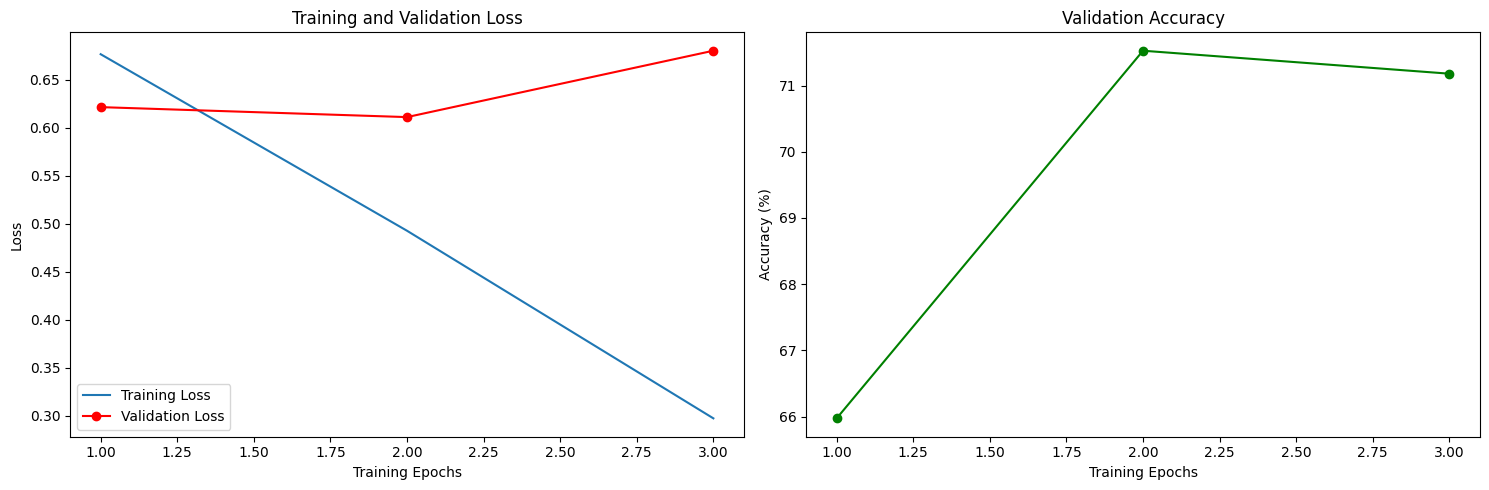

Best Hyperparameters:
lr: 2.6934802228452772e-05
n_epochs: 3
max_length: 64
batch_size: 16
dropout_rate: 0.10754239028638019

Final Evaluation Results:
Validation Accuracy: 71.53%

Training Statistics:
       training_loss  valid_loss  valid_accuracy training_time
epoch                                                         
1           0.676341    0.621233       65.972222       0:00:00
2           0.492487    0.610843       71.527778       0:00:00
3           0.297130    0.679981       71.180556       0:00:00


In [ ]:
print("Part 2: Mean Pooling BERT Model for Text Classification")
n_trials = 10
print(f"Running hyperparameter optimization with {n_trials} trials")

# Run hyperparameter tuning
best_model, best_val_acc, best_params, loss_values, val_acc_values, val_loss_values, df_stats = run_hyperparameter_tuning(n_trials)

# Save best parameters to file
with open('best_params.txt', 'w') as f:
    f.write(f"Strategy: Mean Pooling\n")
    for key, value in best_params.items():
        f.write(f"{key}: {value}\n")
    f.write(f"Validation Accuracy: {best_val_acc:.2f}%\n")

# Evaluate on test set
device = get_device()
loader, _ = init_loader(max_length=best_params["max_length"], batch_size=best_params["batch_size"])

best_model.eval()
nb_test_steps = 0

for batch in loader["test"]:
    b_input_ids, b_input_mask, b_token_type_ids, b_labels = tuple(t.to(device) for t in batch)

    with torch.no_grad():
        outputs = best_model(
            b_input_ids,
            attention_mask=b_input_mask,
            token_type_ids=b_token_type_ids
        )
        logits = outputs.logits

    if isinstance(logits, torch.Tensor):
        logits = logits.detach().cpu().numpy()
        preds = np.argmax(logits, axis=1).flatten()
    else:
        preds = np.argmax(logits.detach().cpu().numpy(), axis=1).flatten()

    label_ids = b_labels.to("cpu").numpy()
    nb_test_steps += 1

# Plot training history
steps = list(range(1, len(loss_values) + 1))
eval_steps = steps

plt.figure(figsize=(15, 5))

# Plot training loss
plt.subplot(1, 2, 1)
plt.plot(steps, loss_values, label="Training Loss")
plt.plot(eval_steps, val_loss_values, 'ro-', label="Validation Loss")
plt.xlabel("Training Epochs")
plt.ylabel("Loss")
plt.title("Training and Validation Loss")
plt.legend()

# Plot accuracy
plt.subplot(1, 2, 2)
plt.plot(eval_steps, val_acc_values, 'go-')
plt.xlabel("Training Epochs")
plt.ylabel("Accuracy (%)")
plt.title("Validation Accuracy")
plt.tight_layout()
plt.savefig("mean-pooling-bert-finetuned-rte-metrics.png")
plt.show()

print("Best Hyperparameters:")
for param, value in best_params.items():
    print(f"{param}: {value}")

print("\nFinal Evaluation Results:")
print(f"Validation Accuracy: {best_val_acc:.2f}%")

print("\nTraining Statistics:")
print(df_stats)